In [1]:
#Librerías a Utilizar
import pandas as pd
import numpy as np
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

In [2]:
#Importando Clases  
data_dir = './Sign-Language-Digits-Dataset'
classes = os.listdir(data_dir + "/Dataset")
print("Clases de Dataset", classes)    

Clases de Dataset ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [3]:
# Importando Dataset
dataset = ImageFolder(data_dir+'/Dataset', transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(64), torchvision.transforms.ToTensor()]))

In [4]:
#Ejemplo de imagenes:
def ejemplo(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  0 (0)


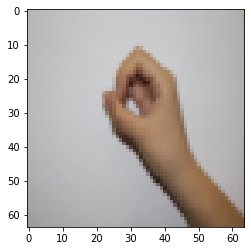

In [5]:
ejemplo(*dataset[0])

Label:  0 (0)


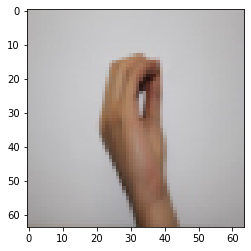

In [6]:
ejemplo(*dataset[2])

In [7]:
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1856, 206)

In [8]:
print("Tamaño Dataset Entrenamiento", train_size)
test_size=50
train_size = len(train_ds) - test_size

train_ds, test_ds = random_split(train_ds, [train_size, test_size])
len(train_ds), len(test_ds)

Tamaño Dataset Entrenamiento 1856


(1806, 50)

# Prueba 1, con Pytorch

In [9]:
#Definiendo tamaño del batch
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
#Creando la clase de ImageClassification, para validar paso a paso  y generar predicciones
#Training y Validation
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Predicciones Training
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Predicciones Validacion
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
class SignLangCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32X32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Flatten(), 
            nn.Linear(16384, 8192),
            nn.ReLU(),
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [12]:

model = SignLangCnnModel()
model

SignLangCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=16384, out_features=8192, bias=True)
    (17): ReLU()
    (18): Linear(in_features=8192, out_featur

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
#device = get_default_device()
device = torch.device('cpu')
device

device(type='cpu')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [16]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.0001

In [18]:
evaluate(model, val_dl)

{'val_loss': 2.3020644187927246, 'val_acc': 0.10679611563682556}

In [19]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.3045, val_loss: 2.3028, val_acc: 0.1068
Epoch [1], train_loss: 2.3028, val_loss: 2.3030, val_acc: 0.1068
Epoch [2], train_loss: 2.2979, val_loss: 2.2909, val_acc: 0.1019
Epoch [3], train_loss: 2.1819, val_loss: 1.8631, val_acc: 0.4660
Epoch [4], train_loss: 1.4621, val_loss: 1.4733, val_acc: 0.4369
Epoch [5], train_loss: 1.0494, val_loss: 0.8684, val_acc: 0.7136
Epoch [6], train_loss: 0.7912, val_loss: 0.6045, val_acc: 0.7864
Epoch [7], train_loss: 0.6829, val_loss: 0.5154, val_acc: 0.8301
Epoch [8], train_loss: 0.5035, val_loss: 0.3587, val_acc: 0.8981
Epoch [9], train_loss: 0.4254, val_loss: 0.3400, val_acc: 0.9126
Epoch [10], train_loss: 0.3659, val_loss: 0.4279, val_acc: 0.8738
Epoch [11], train_loss: 0.3432, val_loss: 0.2957, val_acc: 0.9078
Epoch [12], train_loss: 0.2491, val_loss: 0.2535, val_acc: 0.9320
Epoch [13], train_loss: 0.2109, val_loss: 0.2182, val_acc: 0.9515
Epoch [14], train_loss: 0.2084, val_loss: 0.3172, val_acc: 0.8786
Epoch [15], train_lo

In [43]:
history

[{'val_loss': 2.3028483390808105,
  'val_acc': 0.10679611563682556,
  'train_loss': 2.304457187652588},
 {'val_loss': 2.3029749393463135,
  'val_acc': 0.10679611563682556,
  'train_loss': 2.3028130531311035},
 {'val_loss': 2.290879249572754,
  'val_acc': 0.10194174945354462,
  'train_loss': 2.2979280948638916},
 {'val_loss': 1.863071322441101,
  'val_acc': 0.4660194218158722,
  'train_loss': 2.181894540786743},
 {'val_loss': 1.47329580783844,
  'val_acc': 0.43689319491386414,
  'train_loss': 1.4620918035507202},
 {'val_loss': 0.868367075920105,
  'val_acc': 0.7135922312736511,
  'train_loss': 1.0493539571762085},
 {'val_loss': 0.6044613718986511,
  'val_acc': 0.7864077687263489,
  'train_loss': 0.7911746501922607},
 {'val_loss': 0.5153529644012451,
  'val_acc': 0.8300970792770386,
  'train_loss': 0.6828641891479492},
 {'val_loss': 0.35873112082481384,
  'val_acc': 0.8980582356452942,
  'train_loss': 0.5035483837127686},
 {'val_loss': 0.3399820923805237,
  'val_acc': 0.9126213788986206,

In [ ]:
results = model.evaluate(test_sequences, y_test, verbose=0)

In [ ]:
np_array = np.array(history)

In [ ]:
reshaped_array = np.reshape(np_array, (15, 1))

In [ ]:
reshaped_array

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[6]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[2]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[4]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

# Prueba 2, con Keras

In [21]:
X = np.load('./X.npy')
Y = np.load('./Y.npy')

In [22]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.20, random_state = 42)

xTrain = xTrain.reshape(-1,64,64,1)
xTest = xTest.reshape(-1,64,64,1)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(1649, 64, 64, 1)
(1649, 10)
(413, 64, 64, 1)
(413, 10)


In [23]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation = 'relu', input_shape = (64,64,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [24]:
optimizer = Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999)

In [25]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics = ["accuracy"])

In [26]:
epochs = 30 # 1 epoch means 1 forward and 1 backward pass.
batch_size = 20

In [27]:
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # dimesion reduction
        rotation_range = 10,  # randomly rotate images in the range 10 degrees
        zoom_range = 0.1, # Randomly zoom image 1%
        width_shift_range = 0.1,  # randomly shift images horizontally 1%
        height_shift_range = 0.1,  # randomly shift images vertically 1%
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images

datagen.fit(xTrain)

In [28]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [29]:
history2 = model.fit_generator(datagen.flow(xTrain,
                                           yTrain, 
                                           batch_size = batch_size), 
                              epochs = 30, 
                              validation_data = (xTest, yTest), 
                              steps_per_epoch = xTrain.shape[0] // batch_size,
                              callbacks = [annealer])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
82/82 [==============================] - 102s 1s/step - loss: 2.1539 - accuracy: 0.3106 - val_loss: 3.0616 - val_accuracy: 0.0920
Epoch 2/30
82/82 [==============================] - 103s 1s/step - loss: 1.1240 - accuracy: 0.6231 - val_loss: 4.0282 - val_accuracy: 0.0969
Epoch 3/30
82/82 [==============================] - 105s 1s/step - loss: 0.8572 - accuracy: 0.7262 - val_loss: 4.2973 - val_accuracy: 0.1598
Epoch 4/30
82/82 [==============================] - 104s 1s/step - loss: 0.5859 - accuracy: 0.7931 - val_loss: 3.4001 - val_accuracy: 0.3220
Epoch 5/30
82/82 [==============================] - 103s 1s/step - loss: 0.4669 - accuracy: 0.8514 - val_loss: 4.0951 - val_accuracy: 0.3123
Epoch 6/30
82/82 [==============================] - 103s 1s/step - loss: 0.4140 - accuracy: 0.8643 - val_loss: 0.2825 - val_accuracy: 0.9104
Epoch 7/30
82/82 [==============================] - 103s 1s/step - loss: 0.330

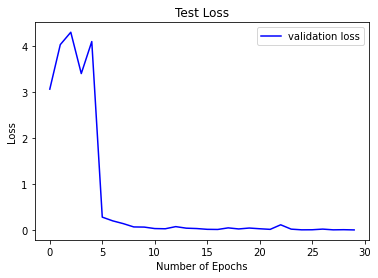

In [30]:
plt.plot(history2.history['val_loss'], color = 'b', label = "validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



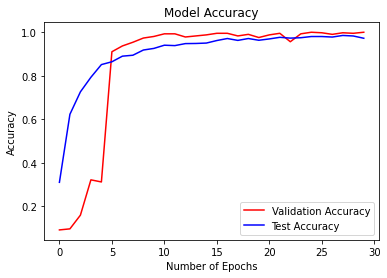

In [40]:
plt.plot(history2.history['val_accuracy'], color = 'r', label = "Validation Accuracy")
plt.plot(history2.history['accuracy'], color = 'b', label = "Test Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


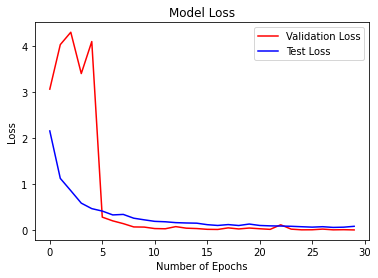

In [41]:
plt.plot(history2.history['val_loss'], color = 'r', label = "Validation Loss")
plt.plot(history2.history['loss'], color = 'b', label = "Test Loss")
plt.title("Model Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()